In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# nvcc version 확인
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
!nvidia-smi

Tue Dec  3 14:46:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [4]:
# 필수 Package import
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [7]:
import os
import torch
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [10]:
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA A100-SXM4-40GB


In [11]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())
print('Current cuda device:', torch.cuda.current_device())

Device: cuda
Count of using GPUs: 1
Current cuda device: 0


In [12]:
# 이미지를 출력하는 함수
def display_images(image_paths, title, max_images=4):
    """지정된 경로의 이미지를 최대 4개까지 출력합니다."""
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[:max_images]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

<Figure size 1200x300 with 0 Axes>

Train chihuahua 총 이미지 수: 0


<Figure size 1200x300 with 0 Axes>

Train muffin 총 이미지 수: 0


<Figure size 1200x300 with 0 Axes>

Val chihuahua 총 이미지 수: 0


<Figure size 1200x300 with 0 Axes>

Val muffin 총 이미지 수: 0


<Figure size 1200x300 with 0 Axes>

Test chihuahua 총 이미지 수: 0


<Figure size 1200x300 with 0 Axes>

Test muffin 총 이미지 수: 0


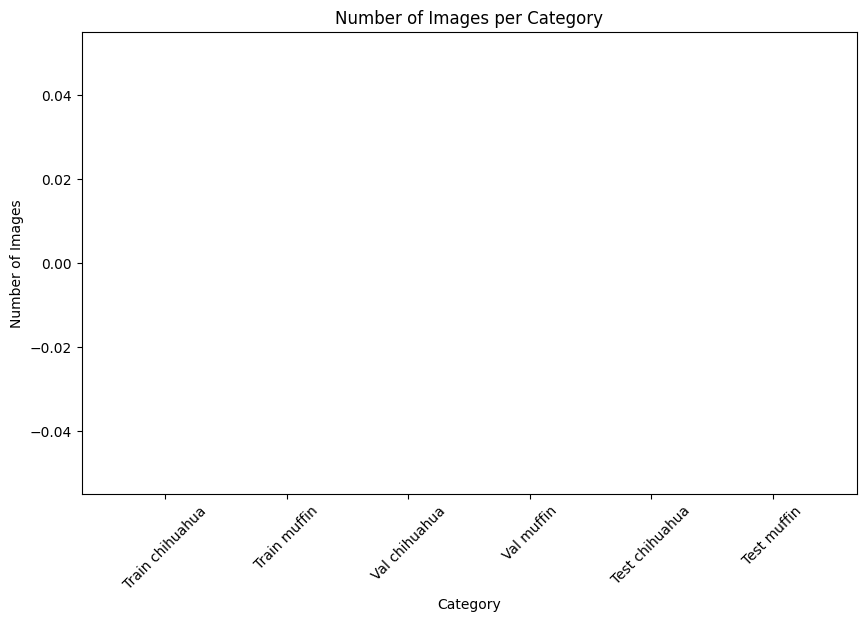

In [13]:
# 이미지와 바 그래프 출력
categories = ['Train chihuahua', 'Train muffin', 'Val chihuahua', 'Val muffin', 'Test chihuahua', 'Test muffin']


for category in categories:
    image_paths = glob.glob(f'/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

# 바 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [14]:
from imgaug import augmenters as iaa
import imgaug as ia

# imgaug를 사용한 커스텀 데이터셋 정의
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.LinearContrast((0.75, 1.5)),  # 대비 조절
            iaa.Crop(percent=(0, 0.2)),  # 이미지의 0%에서 10%까지 무작위로 잘라냄
            iaa.GaussianBlur(sigma=(0.0, 3.0)),  # 가우시안 블러
            iaa.AdditiveGaussianNoise(scale=(10, 60)),  # 가우시안 노이즈 추가
            iaa.Fliplr(0.5),  # 50% 확률로 좌우 반전
            iaa.Flipud(0.2),  # 20% 확률로 상하 반전
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),  # -20도에서 20도 사이로 회전
            iaa.Affine(scale=(0.5, 1.5)),  # 50%에서 150% 사이로 확대/축소
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)


# 커스텀 데이터셋 클래스
class CustomDataset(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None):
        super(CustomDataset, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug  # imgaug 매개변수를 직접 저장

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # imgaug 증강 적용
        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            # imgaug는 numpy 배열을 반환하므로, PIL Image로 다시 변환
            img = Image.fromarray(img)

        # ToTensor 및 Normalize 적용
        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [15]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms

pytorch_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [16]:
# 데이터셋 및 데이터 로더 초기화
train_path = '/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/train'
val_path = '/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/val'

train_dataset = CustomDataset(train_path, imgaug=ImgAugTransform(), transform=pytorch_transforms)
val_dataset = CustomDataset(val_path, imgaug=None, transform=pytorch_transforms)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/train'

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
# DataLoader에서 샘플을 이미지를 load해 show하는 함수
def imshow(img, size=(20, 20), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean  # 역정규화
    img = np.clip(img, 0, 1)  # 값이 0과 1 사이에 오도록 클리핑
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
# DataLoader를 이용하여 배치 데이터 가져오기
dataiter = iter(train_loader)
images, _ = next(dataiter)

# 이미지 그리드 생성 및 시각화, nrow를 조정하여 한 줄에 표시되는 이미지의 수 조정
imshow(make_grid(images[:8], nrow=4), size=(20, 10))

<div style="text-align: left;">
    <h1>Resnet Architecture</h1>
    <figure style="text-align: center;">
      <img src="https://drive.google.com/uc?id=1eznCy8heuav9hZvsvnCb6pN0ei1L8wrD" alt="Resnet Architecture" style="display: block; margin-left: auto; margin-right: auto;">
      <figcaption>Karen Simonyan et al., "Very Deep Convolutional Networks for Large-Scale Image Recognition," ICLR, 2015.</figcaption>
    </figure>
</div>


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

# Ex)
# 64 64 256, 256 256 256, 256 256 256 -> 128 128 512, 512 512 512, 512 512 512, 512 512 512 ->
# 256 256 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024, 1024 1024 1024 -> 512 512 2048, 2048 2048 2048, 2048 2048 2048

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [ ]:
# 사전 학습된 resnet50 모델 불러오기
pretrained_resnet50 = models.resnet50(pretrained=True)
# 새로 정의한 모델 인스턴스 생성
net = resnet50(num_classes=1000)


# 사전 학습된 모델의 features 부분에서 가중치 추출
pretrained_keys = set(pretrained_resnet50.state_dict().keys())
# 사전 학습된 모델에서 커스텀 모델로 가중치 복사 시도
result = net.load_state_dict(pretrained_resnet50.state_dict(), strict=False)
# 복사 후 커스텀 모델의 features 부분에서 가중치 추출
custom_keys = set(net.state_dict().keys())


# 성공적으로 복사된 가중치 (커스텀 모델과 사전 학습된 모델 모두에 존재)
successfully_copied_keys = pretrained_keys.intersection(custom_keys)
# 커스텀 모델에 있지만 사전 학습된 모델에 없는 가중치
missing_keys = custom_keys - pretrained_keys
# 사전 학습된 모델에 있지만 커스텀 모델에 없는 가중치
unexpected_keys = pretrained_keys - custom_keys

print("성공적으로 복사된 가중치:", successfully_copied_keys)
print("커스텀 모델에는 있지만 사전 학습된 모델에는 없는 가중치 (누락):", result.missing_keys)
print("사전 학습된 모델에는 있지만 커스텀 모델에는 없는 가중치 (예상치 못한):", result.unexpected_keys) # net 모델에 없는데 pretrained_vgg19 가중치 파일에는 존재하는 항목의 이름이 리스트로 반환

In [ ]:
print(net)

In [ ]:
# 모델의 모든 파라미터를 고정
for param in net.parameters():
    param.requires_grad = False

In [ ]:
# classifier 부분의 가중치는 재학습을 위해 새로 정의
net.fc = nn.Linear(2048, 2)

for param in net.fc.parameters():
    param.requires_grad = True

net = net.to(device)

In [ ]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
import torch.optim as optim

def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=10):
    # optimizer설정
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=0.00003, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 학습/검증 손실과 검증 정확도를 저장할 리스트
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()  # 모델을 학습 모드로 설정
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        net.eval()  # 모델을 평가 모드로 설정
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [ ]:
train_losses_Adam, val_losses_Adam, val_accuracies_Adam = train_model('Adam', net, train_loader, val_loader, criterion)

In [ ]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_Adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_Adam, label='Adam', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가

In [ ]:
class_folders = {
    'chihuahua': '/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/test/chihuahua',
    'muffin': '/content/drive/MyDrive/fastcampus/image_classification/binary_classification/6/test/muffin'
}

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, pytorch_transforms)

        net.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = net(image)
            _, predicted = torch.max(outputs, 1)
        prediction = 'chihuahua' if predicted.item() == 0 else 'muffin'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()